In [3]:
import pickle

with open('results/data/chaos_relaxed_health_session_1.pkl', 'rb') as file:
    data = pickle.load(file)

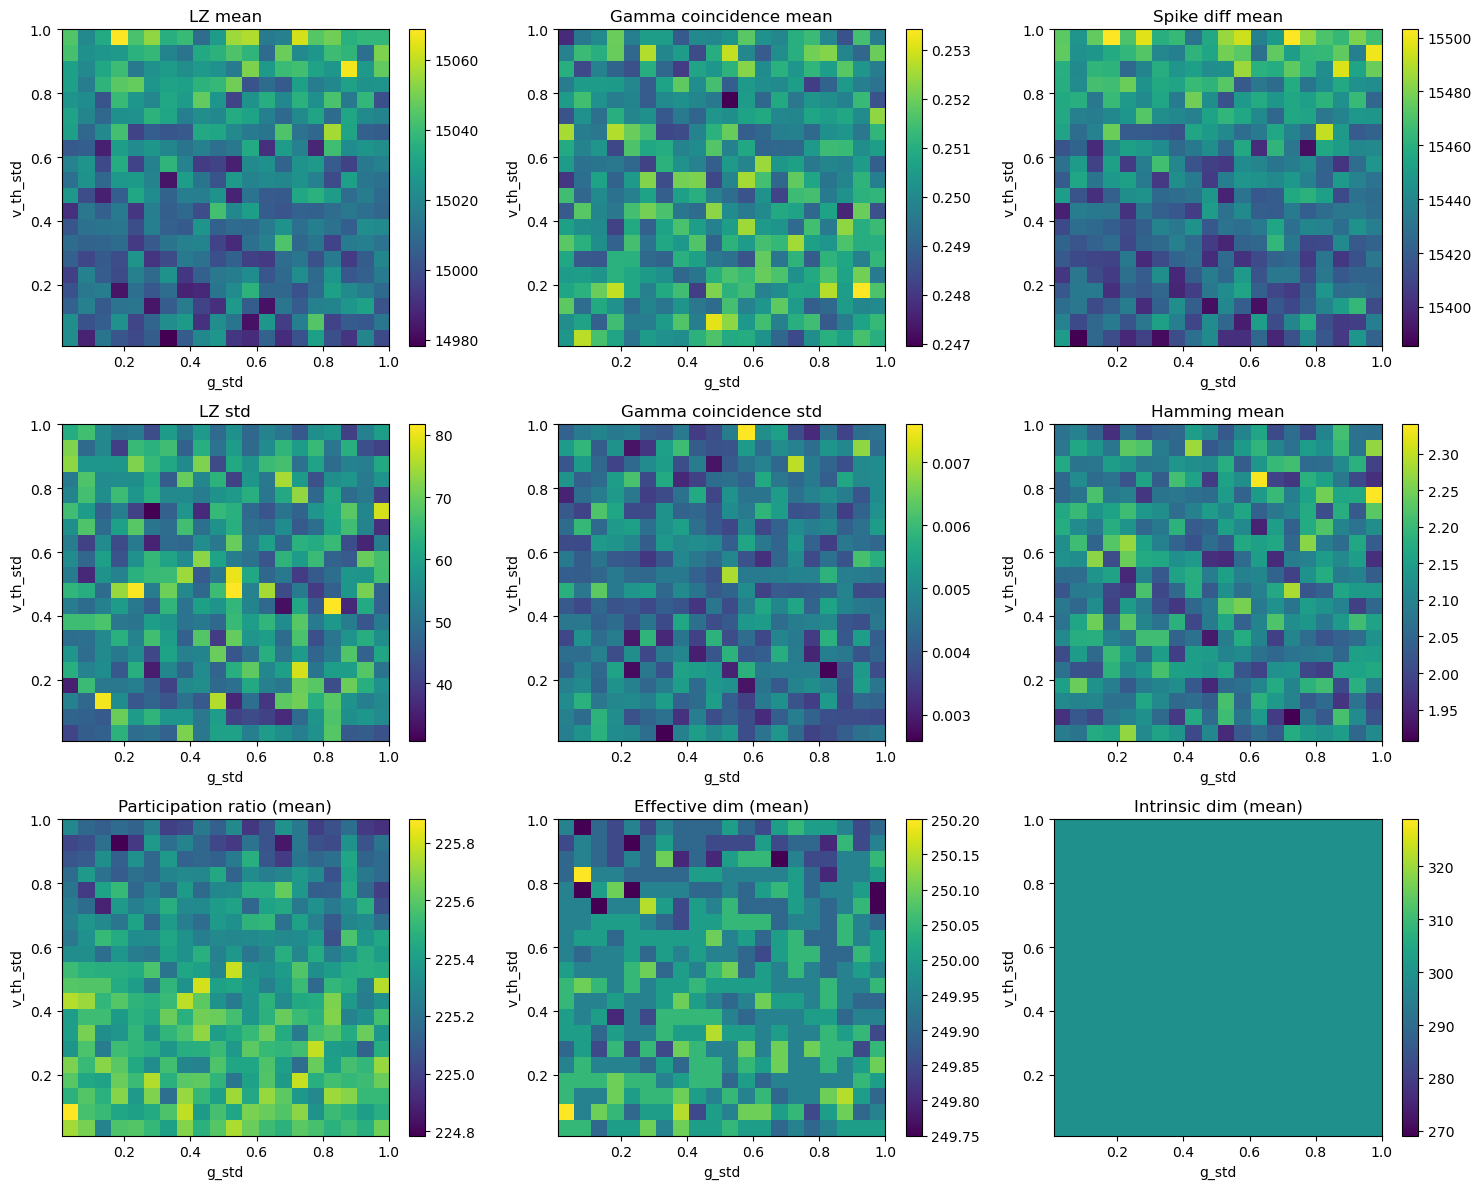

In [10]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load your data
with open('results/data/chaos_relaxed_health_session_1.pkl', 'rb') as file:
    data = pickle.load(file)

# Specify static_input_rate, e.g.:
static_input_rate = 200.0  # <<==== CHANGE TO YOUR DESIRED VALUE

# Extract grid arrays
v_th_stds = sorted(set(entry['v_th_std'] for entry in data if entry['static_input_rate'] == static_input_rate))
g_stds = sorted(set(entry['g_std'] for entry in data if entry['static_input_rate'] == static_input_rate))

# Prepare heatmap arrays for each metric
def prepare_heatmap(key):
    arr = np.full((len(v_th_stds), len(g_stds)), np.nan)
    for entry in data:
        if entry['static_input_rate'] == static_input_rate:
            i = v_th_stds.index(entry['v_th_std'])
            j = g_stds.index(entry['g_std'])
            arr[i, j] = entry.get(key, np.nan)
    return arr

heatmap_keys = [
    ['lz_mean', 'gamma_coincidence_mean', 'spike_diff_mean'],
    ['lz_std', 'gamma_coincidence_std', 'hamming_mean'],
    ['participation_ratio_mean', 'effective_dim_mean', 'intrinsic_dim_mean']
]

titles = [
    ['LZ mean', 'Gamma coincidence mean', 'Spike diff mean'],
    ['LZ std', 'Gamma coincidence std', 'Hamming mean'],
    ['Participation ratio (mean)', 'Effective dim (mean)', 'Intrinsic dim (mean)']
]

fig, axs = plt.subplots(3, 3, figsize=(15, 12))
for row in range(3):
    for col in range(3):
        arr = prepare_heatmap(heatmap_keys[row][col])
        im = axs[row, col].imshow(arr, origin='lower', aspect='auto', cmap='viridis',
                                  extent=[min(g_stds), max(g_stds), min(v_th_stds), max(v_th_stds)])
        axs[row, col].set_title(titles[row][col])
        axs[row, col].set_xlabel('g_std')
        axs[row, col].set_ylabel('v_th_std')
        fig.colorbar(im, ax=axs[row, col])
plt.tight_layout()
plt.show()


In [160]:
a = np.random.normal(-55,2,1000)
a.min(), a.max()

(-61.10342512334207, -48.95016597078648)

In [8]:
data[0]

{'v_th_std': 0.01,
 'g_std': 0.01,
 'static_input_rate': 100.0,
 'lz_complexities': array([5381, 5416, 5408, 5456, 5386, 5513, 5463, 5455, 5469, 5311, 5412,
        5433, 5391, 5430, 5391, 5411, 5456, 5368, 5362, 5343]),
 'hamming_slopes': array([0.92727273, 1.12121212, 1.27272727, 1.23636364, 1.14545455,
        1.15151515, 0.93333333, 0.97575758, 1.01818182, 1.06666667,
        0.98787879, 1.09090909, 1.03030303, 0.96363636, 1.32727273,
        1.30909091, 1.26666667, 1.03030303, 1.23636364, 0.99393939]),
 'lz_mean': 5412.75,
 'lz_std': 47.15705143454158,
 'hamming_mean': 1.1042424242424225,
 'hamming_std': 0.1280725230727016,
 'total_spike_differences': array([3742, 3799, 3796, 3850, 3741, 3894, 3858, 3856, 3850, 3662, 3813,
        3818, 3755, 3826, 3773, 3791, 3848, 3733, 3742, 3702]),
 'spike_diff_mean': 3792.45,
 'spike_diff_std': 58.68004345601663,
 'intrinsic_dimensionalities': array([299., 299., 299., 299., 299., 299., 299., 299., 299., 299., 299.,
        299., 299., 298., 2

1200

In [5]:
import pickle
with open('results/data/chaos_relaxed_health_session_1.pkl', 'rb') as f:
    results = pickle.load(f)

# Check which combinations you have
import numpy as np
v_th_values = sorted(set(r['v_th_std'] for r in results))
g_values = sorted(set(r['g_std'] for r in results))  
input_rates = sorted(set(r['static_input_rate'] for r in results))

print(f"v_th values: {len(v_th_values)} (expected 20)")
print(f"g values: {len(g_values)} (expected 20)")
print(f"input rates: {len(input_rates)} (expected 3)")
print(f"Total combinations: {len(results)} (expected {len(v_th_values) * len(g_values) * len(input_rates)})")

# Check for missing combinations
expected_combinations = set()
for v in v_th_values:
    for g in g_values:
        for r in input_rates:
            expected_combinations.add((v, g, r))

actual_combinations = set((r['v_th_std'], r['g_std'], r['static_input_rate']) for r in results)
missing = expected_combinations - actual_combinations
print(f"Missing {len(missing)} combinations")

v_th values: 20 (expected 20)
g values: 20 (expected 20)
input rates: 10 (expected 3)
Total combinations: 4000 (expected 4000)
Missing 0 combinations


In [6]:
import numpy as np

g_std_list = sorted({entry['g_std'] for entry in data})
v_th_std_list = sorted({entry['v_th_std'] for entry in data}, reverse=True)  # descending y-axis

lz_matrix = np.zeros((len(v_th_std_list), len(g_std_list)))
hamming_matrix = np.zeros((len(v_th_std_list), len(g_std_list)))

for i, v_th in enumerate(v_th_std_list):
    for j, g_std in enumerate(g_std_list):
        for entry in data:
            if entry['g_std'] == g_std and entry['v_th_std'] == v_th:
                lz_matrix[i, j] = entry['lz_mean']
                hamming_matrix[i, j] = entry['hamming_mean']
                break

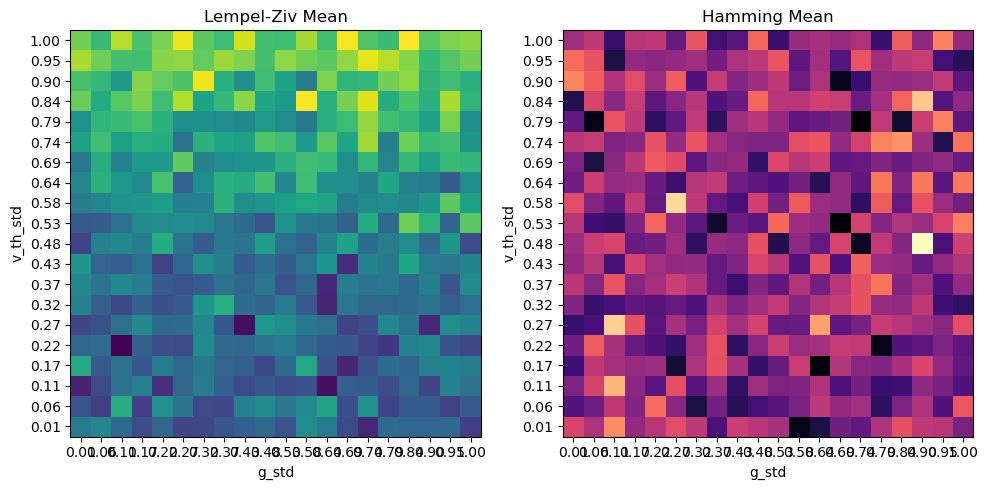

In [7]:
import matplotlib.pyplot as plt

fig, axarr = plt.subplots(1, 2, figsize=(10, 5))

# Plot lz_mean heatmap
im1 = axarr[0].imshow(lz_matrix, aspect='auto', cmap='viridis', origin='upper')
axarr[0].set_title('Lempel-Ziv Mean')
axarr[0].set_xlabel('g_std')
axarr[0].set_ylabel('v_th_std')
axarr[0].set_xticks(np.arange(len(g_std_list)))
axarr[0].set_xticklabels([f'{g:.2f}' for g in g_std_list])
axarr[0].set_yticks(np.arange(len(v_th_std_list)))
axarr[0].set_yticklabels([f'{v:.2f}' for v in v_th_std_list])

# Plot hamming_mean heatmap
im2 = axarr[1].imshow(hamming_matrix, aspect='auto', cmap='magma', origin='upper')
axarr[1].set_title('Hamming Mean')
axarr[1].set_xlabel('g_std')
axarr[1].set_ylabel('v_th_std')
axarr[1].set_xticks(np.arange(len(g_std_list)))
axarr[1].set_xticklabels([f'{g:.2f}' for g in g_std_list])
axarr[1].set_yticks(np.arange(len(v_th_std_list)))
axarr[1].set_yticklabels([f'{v:.2f}' for v in v_th_std_list])

plt.tight_layout()
plt.show()


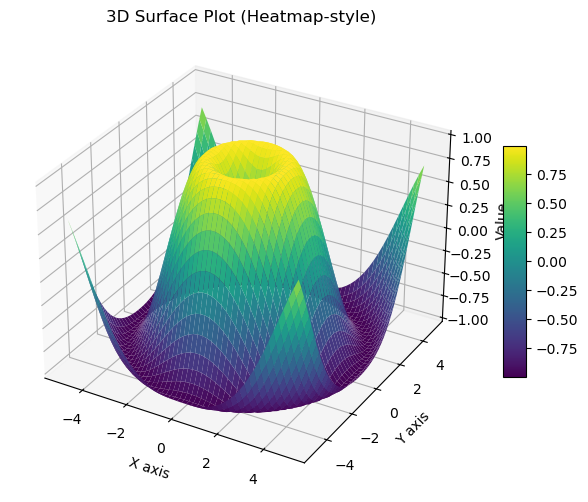

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sample data
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# 3D surface plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
fig.colorbar(surf, shrink=0.5, aspect=10)

ax.set_title('3D Surface Plot (Heatmap-style)')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Value')

plt.show()


In [22]:
def gamma_coincidence(spike_train1, spike_train2, window=0.005):
    spike_train1 = sorted(spike_train1)
    spike_train2 = sorted(spike_train2)
    
    count_coincidences = 0
    i, j = 0, 0
    
    while i < len(spike_train1) and j < len(spike_train2):
        dt = spike_train1[i] - spike_train2[j]
        if abs(dt) <= window:
            count_coincidences += 1
            i += 1
            j += 1
        elif dt < 0:
            i += 1
        else:
            j += 1
    
    norm = (len(spike_train1) + len(spike_train2)) / 2
    if norm == 0:
        return 0
    return count_coincidences / norm


def average_gamma_coincidence(network1, network2, window=0.005):
    """
    Compute average normalized gamma coincidence between two networks.
    
    Args:
        network1: list of tuples (neuron_id, spike_time)
        network2: list of tuples (neuron_id, spike_time)
        window: coincidence time window (seconds)
    
    Returns:
        Average normalized gamma coincidence across corresponding neurons.
    """
    from collections import defaultdict
    
    # Organize spike trains by neuron_id
    spikes_net1 = defaultdict(list)
    spikes_net2 = defaultdict(list)
    
    for neuron_id, spike_time in network1:
        spikes_net1[neuron_id].append(spike_time)
    for neuron_id, spike_time in network2:
        spikes_net2[neuron_id].append(spike_time)
    
    neuron_ids = set(spikes_net1.keys()) & set(spikes_net2.keys())
    if not neuron_ids:
        return None  # No overlapping neurons
    
    coincidences = []
    for neuron_id in neuron_ids:
        c = gamma_coincidence(spikes_net1[neuron_id], spikes_net2[neuron_id], window=window)
        coincidences.append(c)
    
    return sum(coincidences) / len(coincidences)




In [27]:
# Example usage:
network1 = [
    (1, 0.01), (1, 0.02), (1, 0.03),
    (2, 0.05), (2, 0.10),
    (3, 0.07), (3, 0.08)
]

network2 = [
    (1, 0.015), (1, 0.025),
    (2, 0.055), (2, 0.12),
    (3, 0.09), (3, 0.10)
]

avg_gamma = average_gamma_coincidence(network1, network2, window=0.005)
print(f"Average gamma coincidence across neurons: {avg_gamma:.3f}")


Average gamma coincidence across neurons: 0.433


In [30]:
# Example usage:
network1 = [
    (1, 0.01), (1, 0.02), (1, 0.03),
    (2, 0.05), (2, 0.10),
    (3, 0.07), (3, 0.08)
]

network2 = [
    (1, 0.015), (1, 0.025),
    (2, 0.055), (2, 0.12),
    (3, 0.07), (3, 0.10), (3, 0.30)
]

avg_gamma = average_gamma_coincidence(network1, network2, window=0.005)
print(f"Average gamma coincidence across neurons: {avg_gamma:.3f}")


Average gamma coincidence across neurons: 0.567


In [33]:
T_sim_init = 300
T_sim = 300
dt = 0.1


reps = 25
reps = 1
trials = 20
n_neurons = 1000


rng = np.random.default_rng(np.random.SeedSequence(entropy=654321, spawn_key=(0, 1)))

In [155]:
def input_signal(T, dt, n_neurons, rng, rep_ind):
    n_steps = int(T / dt)
    time = np.arange(0, T, dt)

    # Generate slow, complex, non-periodic signal using filtered noise
    np.random.seed(7+rep_ind)
    raw_noise = np.random.randn(n_steps)

    # Low-pass filter for slow oscillations (cutoff ~2 Hz)
    b, a = butter(N=5, Wn=0.007)  # Wn = (2 Hz) / (1/(2*dt*1e-3)) = 2/(1/(2*0.1e-3)) = 0.004
    slow_signal = filtfilt(b, a, raw_noise)

    # Apply a window to force start and end at zero (Hann window)
    window = np.hanning(n_steps)
    slow_signal *= window

    # Normalize to [0, 7]
    slow_signal -= slow_signal.min()
    slow_signal /= slow_signal.max()
    slow_signal *= 1

    # Apply a window to force start and end at zero (Hann window)
    window = np.hanning(n_steps)
    slow_signal *= window

    # Normalize to [0, 7]
    slow_signal -= slow_signal.min()
    slow_signal /= slow_signal.max()
    slow_signal *= 3

    return slow_signal + 1 * rng.normal(size=(n_neurons, len(time))), slow_signal.reshape(1,-1)

In [156]:
from scipy.signal import butter, filtfilt
inp = input_signal(T_sim, 0.1, n_neurons, rng, 1)

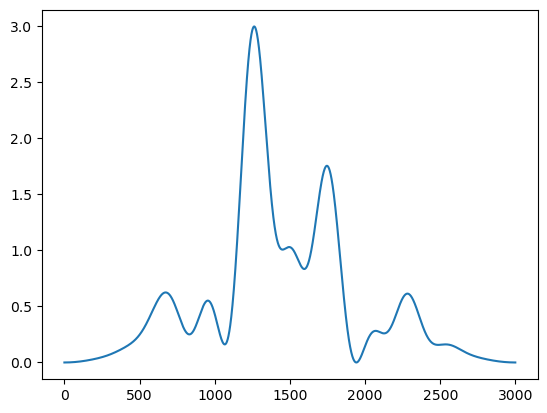

In [157]:
plt.plot(inp[1][0,:])

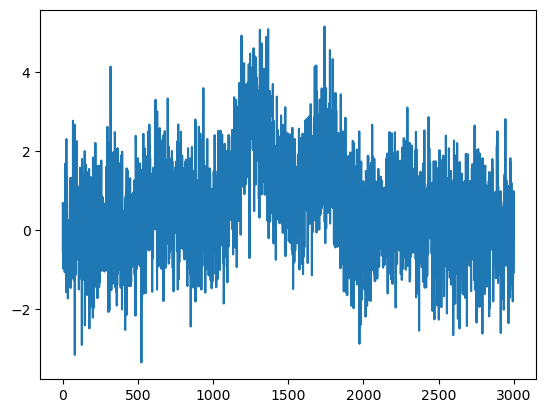

In [142]:
plt.plot(inp[0][1,:])

In [43]:
inp[1].shape

(1, 3000)

In [133]:
import numpy as np
from sklearn.decomposition import PCA

def generate_temporal_signals(hidden_dim, n_channels=20, duration_ms=300, dt_ms=0.1):
    '''
    Generate synthetic temporal signals with controlled hidden dimensionality.

    Args:
      hidden_dim: int, intrinsic hidden dimensionality (1 to 20)
      n_channels: int, total number of channels (default 20)
      duration_ms: int, total duration in ms (default 300 ms)
      dt_ms: float, time resolution in ms (default 0.1 ms)

    Returns:
      signals: np.array shape (n_channels, n_timepoints), synthetic signals
      actual_dim: float, estimated dimensionality from PCA
    '''
    n_timepoints = int(duration_ms / dt_ms)

    # Generate hidden_dim independent temporal basis signals
    # Each starts and ends at zero
    t = np.linspace(0, duration_ms, n_timepoints)
    bases = []
    for i in range(hidden_dim):
        # Create smooth random waves with zero start/end
        phase = np.random.rand() * 4 * np.pi
        freq = np.random.uniform(1, 10)  # random freq between 1 and 10 Hz
        wave = np.sin(2 * np.pi * freq * t / 1000 + phase)  # convert ms to s
        wave *= np.sin(np.pi * t / duration_ms)  # envelope to zero at edges
        bases.append(wave)
    bases = np.array(bases)  # shape (hidden_dim, n_timepoints)

    # Mix the bases to generate n_channels signals
    mixing_matrix = np.random.randn(n_channels, hidden_dim)
    signals = mixing_matrix @ bases  # shape (n_channels, n_timepoints)

    # Normalize signals between -1 and 1
    signals = (signals - signals.min(axis=1, keepdims=True)) / (signals.max(axis=1, keepdims=True) - signals.min(axis=1, keepdims=True))
    signals = signals * 2 - 1

    # Estimate dimensionality via PCA
    pca = PCA()
    pca.fit(signals.T)  # transpose to shape (timepoints, channels)
    explained_var_ratio = pca.explained_variance_ratio_
    # Calculate actual dimensionality (effective rank) as participation ratio
    actual_dim = 1 / np.sum(explained_var_ratio**2)

    return signals, actual_dim


# Example usage:
signals, actual_dim = generate_temporal_signals(hidden_dim=5)
print(f'Signals shape: {signals.shape}, Actual estimated dimensionality: {actual_dim:.2f}')


Signals shape: (20, 3000), Actual estimated dimensionality: 2.58


In [134]:
signals.shape

(20, 3000)

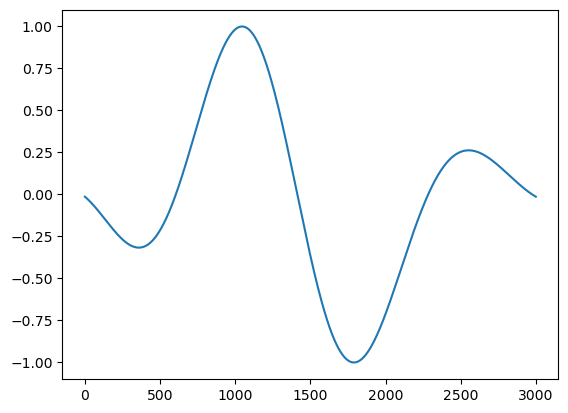

In [135]:
plt.plot(signals[0])

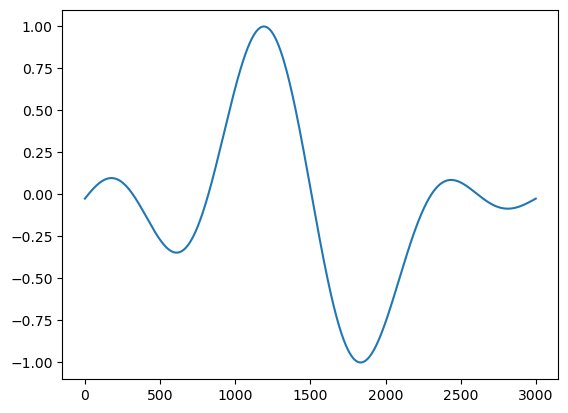

In [71]:
plt.plot(signals[1])

In [83]:
import numpy as np
from sklearn.decomposition import PCA

def generate_complex_positive_temporal_signals(hidden_dim, n_channels=20, duration_ms=300, dt_ms=0.1):
    n_timepoints = int(duration_ms / dt_ms)
    t = np.linspace(0, duration_ms, n_timepoints)

    def gaussian_pulse(t, center, width):
        return np.exp(- ((t - center) ** 2) / (2 * width ** 2))

    bases = []
    for i in range(hidden_dim):
        # Random pulse parameters
        center = np.random.uniform(0.1*duration_ms, 0.9*duration_ms)
        width = np.random.uniform(0.01*duration_ms, 0.1*duration_ms)
        pulse = gaussian_pulse(t, center, width)

        # Modulate with positive raised cosine envelope to ensure zero edges
        envelope = 0.5 * (1 - np.cos(np.pi * t / duration_ms))
        base_signal = pulse * envelope

        bases.append(base_signal)
    bases = np.array(bases)

    # Mixing to create channels
    mixing_matrix = np.random.randn(n_channels, hidden_dim)
    signals = mixing_matrix @ bases

    # Shift each channel signal to positive and normalize max to 1
    signals = signals - signals.min(axis=1, keepdims=True)
    signals = signals / signals.max(axis=1, keepdims=True)

    # PCA for actual dimensionality
    pca = PCA()
    pca.fit(signals.T)
    explained_var_ratio = pca.explained_variance_ratio_
    actual_dim = 1 / np.sum(explained_var_ratio ** 2)

    return signals, actual_dim

# Test example
signals, actual_dim = generate_complex_positive_temporal_signals(hidden_dim=1)
print(f'Signals shape: {signals.shape}, Estimated dimensionality: {actual_dim:.2f}')


Signals shape: (20, 3000), Estimated dimensionality: 1.00


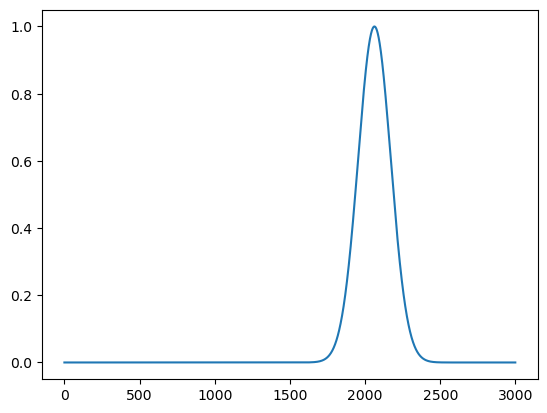

In [85]:
plt.plot(signals[1])

In [131]:
import numpy as np
from scipy.signal import butter, filtfilt

def generate_filtered_noise_signal(duration_ms=300, dt_ms=0.1, cutoff_freq_hz=30):
    n_timepoints = int(duration_ms / dt_ms)
    t = np.linspace(0, duration_ms, n_timepoints)

    # Step 1: Generate white Gaussian noise
    white_noise = np.random.randn(n_timepoints)

    # Step 2: Design Butterworth low-pass filter
    fs = 1000 / dt_ms  # Sampling frequency in Hz
    nyq = fs / 2
    normal_cutoff = cutoff_freq_hz / nyq
    b, a = butter(N=4, Wn=normal_cutoff, btype='low')

    # Step 3: Apply zero-phase filter
    filtered_noise = filtfilt(b, a, white_noise)

    # Step 4: Shape signal to start and end near zero using raised cosine envelope
    envelope = 0.5 * (1 - np.cos(np.pi * t / duration_ms))
    signal = filtered_noise * envelope

    # Normalize signal to [0, 1]
    signal -= signal.min()
    signal /= signal.max()

    return signal

# Example use
signal = generate_filtered_noise_signal()
print(f'Signal shape: {signal.shape}')


Signal shape: (3000,)


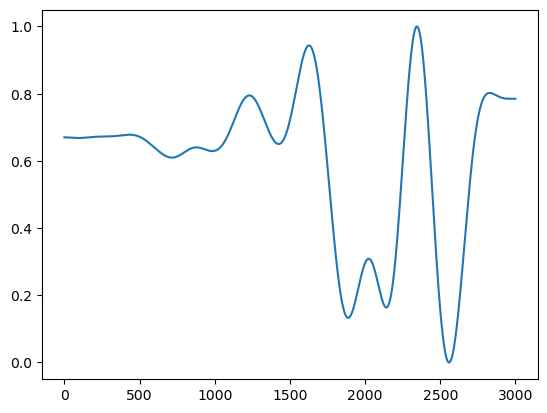

In [132]:
plt.plot(signal)

In [221]:
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.decomposition import PCA

def generate_filtered_noise_signals(n_channels, n_dim, T, dt, seed=None):
    n_steps = int(T / dt)
    time = np.arange(0, T, dt)
    rng = np.random.default_rng(seed)
    
    signals_list = []
    for i in range(n_dim):
        raw_noise = rng.standard_normal(10*n_steps)
        cutoff = rng.uniform(4, 6)  # random cutoff in 4-7 Hz
        
        Wn = cutoff / 1000
        b, a = butter(N=5, Wn=Wn, btype='low')
        
        slow_signal = filtfilt(b, a, raw_noise)
        
        # Apply Hann window twice for smooth zero edges
        window = np.hanning(10*n_steps)
        slow_signal *= window
        # Normalize to [0, 3]
        slow_signal -= slow_signal.min()
        slow_signal /= slow_signal.max()
        slow_signal *= 3
        
        start = rng.integers(9*n_steps)
        signals_list.append(slow_signal[start:start+n_steps])
    
    # Stack signals (n_dim, n_steps)
    base_signals = np.array(signals_list)
    
    # Assign these signals randomly to channels (with replacement)
    assignments = rng.choice(n_dim, size=n_channels, replace=True)
    
    signals = base_signals[assignments]
    
    # Estimate dimensionality by PCA
    pca = PCA()
    pca.fit(signals.T)
    evr = pca.explained_variance_ratio_
    estimated_dim = 1 / np.sum(evr ** 2) if len(evr) > 0 else 0
    
    return signals, estimated_dim


# Example call
signals, dim = generate_filtered_noise_signals(n_channels=20, n_dim=20, T=300, dt=0.1, seed=103)
print(f'Signals shape: {signals.shape}, Estimated dimensionality: {dim:.2f}')


Signals shape: (20, 3000), Estimated dimensionality: 4.25


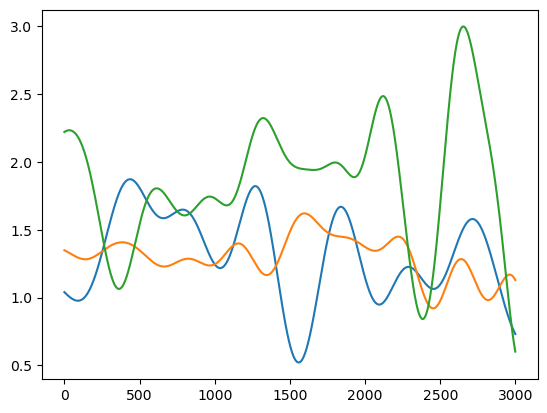

In [222]:
plt.plot(signals[0])
plt.plot(signals[1])
plt.plot(signals[9])

In [172]:
np.random.randn(2)

array([-0.73405467,  1.11006382])

In [215]:
rng.integers(100)

11

In [165]:
signals, dim = generate_complex_input_signals(n_channels=20, n_dim=3, T=300, dt=0.1, seed=42)
    print(f"Generated signals shape: {signals.shape} — Estimated dimensionality: {dim:.2f}")

Generated signals shape: (20, 3000) — Estimated dimensionality: 1.96


In [160]:
signals.shape

(20, 3000)

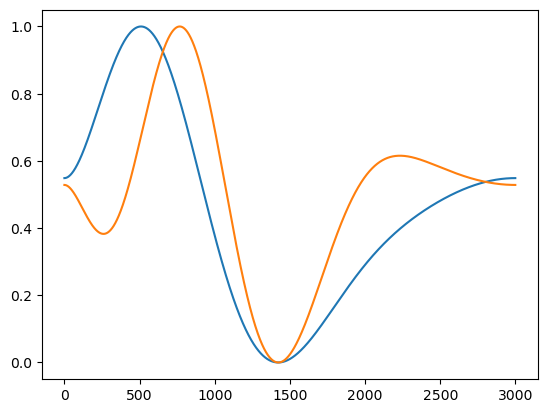

In [163]:
plt.plot(signals[0])
plt.plot(signals[1])


Signal length: 3000, Time duration: 299.90000000000003 ms


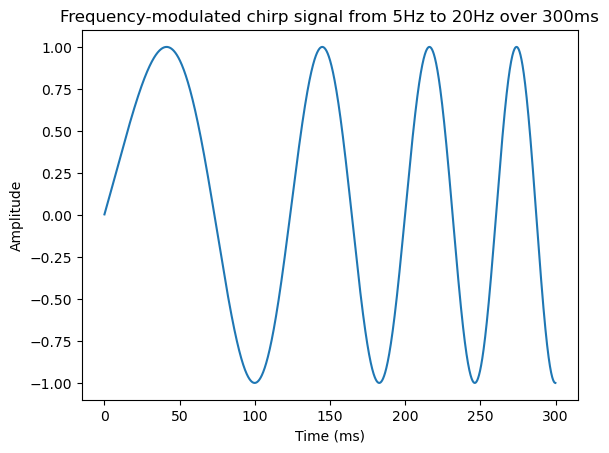

In [229]:
import numpy as np
import matplotlib.pyplot as plt

def generate_chirp(T=300, dt=0.1, f_start=5, f_end=20):
    """
    Generate a frequency-modulated (chirp) signal:
    frequency changes linearly from f_start to f_end over time T.

    Args:
        T (float): duration in ms
        dt (float): time resolution in ms
        f_start (float): starting frequency in Hz
        f_end (float): ending frequency in Hz

    Returns:
        t (np.ndarray): time array (ms)
        signal (np.ndarray): frequency-modulated signal (amplitude range [-1,1])
    """
    t = np.arange(0, T, dt)  # time vector
    t_sec = t / 1000  # convert ms to seconds for frequency formula
    
    # Instantaneous frequency changes linearly
    f_t = f_start + (f_end - f_start) * (t_sec / t_sec[-1])
    
    # Instantaneous phase = integral of 2*pi*frequency
    phase = 2 * np.pi * np.cumsum(f_t) * dt / 1000  # dt in seconds here
    
    signal = np.sin(phase)
    return t, signal

# Example usage:
t, sig = generate_chirp()
print(f"Signal length: {len(sig)}, Time duration: {t[-1]} ms")

import matplotlib.pyplot as plt
plt.plot(t, sig)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("Frequency-modulated chirp signal from 5Hz to 20Hz over 300ms")
plt.show()


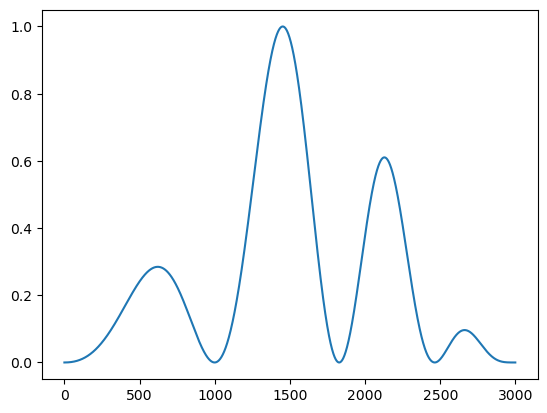

In [230]:
sig = sig+1


window = np.hanning(10*300)
sig *= window
# Normalize to [0, 3]
sig -= sig.min()
sig /= sig.max()
# slow_signal *= 3
plt.plot(sig)

In [260]:
import numpy as np
from sklearn.decomposition import PCA

def generate_multidim_chirps(n_channels, n_dim, T=300, dt=0.1, freq_range=(5, 30), seed=None):
    rng = np.random.default_rng(seed)
    n_timepoints = int(T / dt)
    t = np.arange(0, T, dt)
    t_sec = t / 1000
    
    # Step 1: Generate n_dim base chirps with random freq sweeps
    base_signals = []
    for i in range(n_dim):
        f_start = rng.uniform(*freq_range)
        f_end = rng.uniform(*freq_range)
        f_t = f_start + (f_end - f_start) * (t_sec / t_sec[-1])
        a = rng.random(1)
        phase = a * 2 * np.pi * np.cumsum(f_t) * dt / 1000
        base_signals.append(np.sin(phase))
    base_signals = np.array(base_signals)  # shape (n_dim, n_timepoints)
    
    # Step 2: Assign chirp signals randomly to n_channels
    assignments = rng.choice(n_dim, size=n_channels, replace=True)
    signals = base_signals[assignments]
    
    # Step 3: Estimate actual dimensionality using PCA
    pca = PCA()
    pca.fit(signals.T)
    evr = pca.explained_variance_ratio_
    estimated_dim = 1 / np.sum(evr ** 2) if len(evr) > 0 else 0
    
    return t, signals, estimated_dim


# Example usage
t, signals, dim = generate_multidim_chirps(n_channels=20, n_dim=15, seed=123)
print(f"Signals shape: {signals.shape}, Estimated dimensionality: {dim:.2f}")


Signals shape: (20, 3000), Estimated dimensionality: 3.28


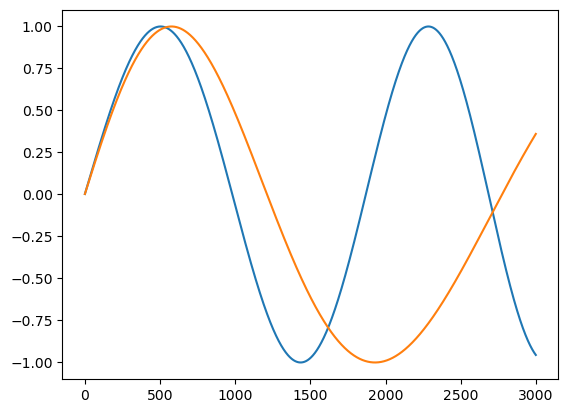

In [259]:
plt.plot(signals[0])
plt.plot(signals[3])

In [165]:
import numpy as np

def simulate_rate_rnn(T=2000, dt=0.1, N=200, g=3.0, tau=10.0, seed=0,
                      nonlinearity='tanh', I_ext=None, sigma_noise=0.0):
    """
    Simulate dx/dt = (-x + W*phi(x) + I_ext)/tau  (Euler integration)
    - T: number of timesteps
    - dt: timestep size
    - N: number of recurrent neurons
    - g: gain for random weights (scale = g / sqrt(N))
    - tau: membrane time constant
    - nonlinearity: 'tanh' or 'sigmoid'
    - I_ext: external input vector shape (T, N) or None
    - sigma_noise: additive gaussian noise std for dx update
    Returns X shape (T, N)
    """
    rng = np.random.default_rng(seed)
    scale = g / np.sqrt(N)
    W = rng.normal(0, scale, size=(N, N))
    x = np.zeros(N)
    X = np.zeros((T, N))
    if I_ext is None:
        I_ext = np.zeros((T, N))

    def phi(u):
        if nonlinearity == 'tanh':
            return np.tanh(u)
        elif nonlinearity == 'sigmoid':
            return 1.0 / (1.0 + np.exp(-u))
        else:
            raise ValueError("nonlinearity must be 'tanh' or 'sigmoid'")

    for t in range(T):
        dx = (-x + W.dot(phi(x)) + I_ext[t]) * (dt / tau)
        if sigma_noise > 0:
            dx += sigma_noise * np.sqrt(dt) * rng.standard_normal(N)
        x = x + dx
        X[t] = x
    return X

# Example usage
T = 3500
N = 300
g = 30.0
X_raw = simulate_rate_rnn(T=T, dt=0.1, N=N, g=g, tau=10.0, seed=42, nonlinearity='tanh', sigma_noise=0.0)

# Remove transient
transient = 500
X = X_raw[transient:].copy()   # shape (T-transient, N)

# Map to [0,1] firing activity.
# If phi was tanh, x in roughly [-1,1] -> use sigmoid or linear rescale
# Option A: apply logistic sigmoid to membrane potentials (biologically plausible rate output)
def to_rate(x):
    return 1.0 / (1.0 + np.exp(-x))   # maps to (0,1)

Rates = to_rate(X)   # shape (T_eff, N)


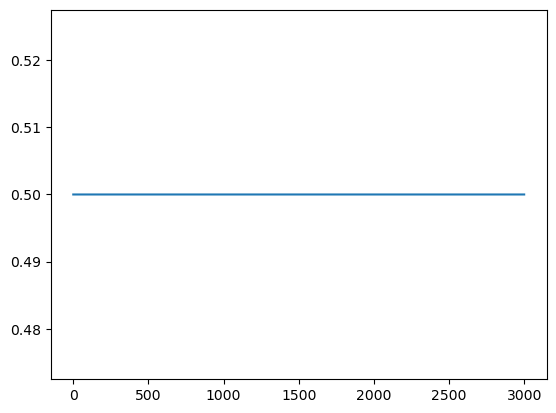

In [166]:
plt.plot(Rates[:,0])

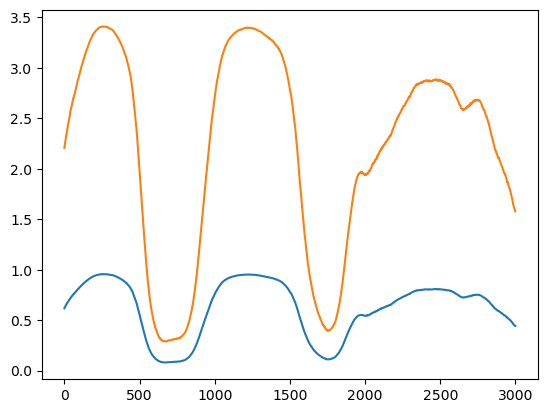

In [351]:
plt.plot(Rates[:,1])
plt.plot((Rates[:,1])/Rates[:,1].std())

In [335]:
pca = PCA()
pca.fit(Rates[:,:50].T)  # shape: (timepoints, channels)
evr = pca.explained_variance_ratio_
participation_ratio = 1 / np.sum(evr**2)
participation_ratio

4.515340907316624

In [346]:
cov_matrix = np.cov(Rates[:,:7].T)

# Compute eigenvalues of covariance matrix
eigenvalues = np.linalg.eigvalsh(cov_matrix)
(eigenvalues.sum())**2/(eigenvalues**2).sum()

2.808471748475754

4.281880349539109

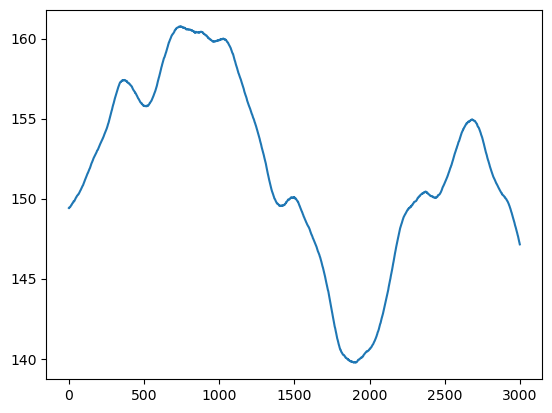

In [298]:
# plt.plot(Rates[:,0])
# plt.plot(Rates[:,1])
plt.plot(Rates.sum(axis=1))

In [320]:
def make_observed_from_latents(Rates, k_latent=5, M_obs=20, method='pick', seed=1):
    """
    - Rates: (T, N) matrix of neuron rates in [0,1]
    - k_latent: number of latent neurons to use (choose k distinct neurons)
    - M_obs: number of observed channels to produce
    - method: 'pick' (use different neurons), 'mix' (random linear mixtures of picked neurons)
    - noise_std: observation noise std added to each observed channel
    Returns Y (T, M_obs), indices of latent neurons
    """
    rng = np.random.default_rng(seed)
    T, N = Rates.shape
    inds = rng.choice(N, size=k_latent, replace=False)
    Latents = Rates[:, inds]  # shape (T, k_latent)

    if method == 'pick':
        # If M_obs <= k_latent, just take the first M_obs latents.
        # If M_obs > k_latent, tile latents or add small jittered copies
        if M_obs <= k_latent:
            Y = Latents[:, :M_obs].copy()
        else:
            # random linear mixing to expand dimensions but keep latent rank = k_latent
            A = rng.normal(0, 1.0, size=(k_latent, M_obs))
            Y = Latents.dot(A)
    elif method == 'mix':
        A = rng.normal(0, 1.0, size=(k_latent, M_obs))
        Y = Latents.dot(A)
    else:
        raise ValueError("method must be 'pick' or 'mix'")

    # Optionally normalize each observed channel to [0,1]
    Y = (Y - Y.min(axis=0, keepdims=True)) / (Y.max(axis=0, keepdims=True) - Y.min(axis=0, keepdims=True) + 1e-12)

    # Compute participation ratio (effective dimensionality)
    pca = PCA()
    pca.fit(Y)  # shape: (timepoints, channels)
    evr = pca.explained_variance_ratio_
    participation_ratio = 1 / np.sum(evr**2)

    return Y, inds, participation_ratio

# Example: want effective dimensionality = 3, but 30 observed channels
Y, lat_inds, pr = make_observed_from_latents(Rates, k_latent=20, M_obs=20, method='mix', seed=5)
print("Y shape:", Y.shape)   # (T_eff, 30)


Y shape: (3000, 20)


In [321]:
pr

3.1403818722188324

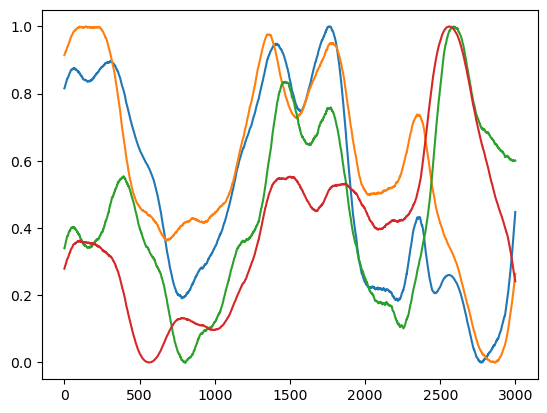

In [305]:
plt.plot(Y[:,0])
plt.plot(Y[:,1])
plt.plot(Y[:,2])
plt.plot(Y[:,4])

In [308]:
import numpy as np
from sklearn.decomposition import PCA

def generate_rnn_inputs(k, M, T, dt, g=3.0, noise_std=0.01, seed=None):
    np.random.seed(seed)
    n_steps = int(T / dt)
    t = np.linspace(0, T, n_steps)

    # Random Gaussian weights for latent neurons
    W = np.random.randn(k, k) / np.sqrt(k)

    # Zero external input
    I_func = lambda time: np.zeros(k)

    # Initial state
    x0 = np.random.randn(k)

    # Euler integration
    x = np.zeros((n_steps, k))
    x[0] = x0

    for i in range(1, n_steps):
        dx = -x[i-1] + g * W @ (1 / (1 + np.exp(-x[i-1]))) + I_func(t[i]) + noise_std * np.random.randn(k)
        x[i] = x[i-1] + dx * dt * 1e-3  # dt in seconds

    # Remove initial transient (first 20%)
    transient_cutoff = int(0.2 * n_steps)
    latent_activity = x[transient_cutoff:]

    # Linear mixing to observed channels
    mixing_matrix = np.random.randn(M, k)
    observed_activity = mixing_matrix @ latent_activity.T  # (M, timepoints)

    # Normalize between 0 and 1
    min_vals = observed_activity.min(axis=1, keepdims=True)
    max_vals = observed_activity.max(axis=1, keepdims=True)
    observed_activity = (observed_activity - min_vals) / (max_vals - min_vals)

    # Compute participation ratio (effective dimensionality)
    pca = PCA()
    pca.fit(observed_activity.T)  # shape: (timepoints, channels)
    evr = pca.explained_variance_ratio_
    participation_ratio = 1 / np.sum(evr**2)

    return t[transient_cutoff:], observed_activity.T, participation_ratio, observed_activity.shape


# Example usage
T = 3000  # ms
dt = 0.01  # ms
k = 5     # intrinsic dimensionality (latent neurons)
M = 20    # observed channels (mixtures)

t, signals, dim, sh = generate_rnn_inputs(k, M, T, dt, seed=42)
print(f"Signals shape: {signals.shape}, Participation ratio (dimensionality): {dim:.2f}")


Signals shape: (240000, 20), Participation ratio (dimensionality): 1.12


In [309]:
sh

(20, 240000)

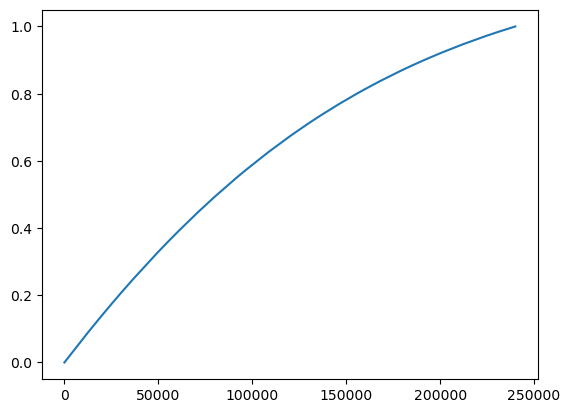

In [295]:
plt.plot(signals[:,2])

In [263]:
import numpy as np

def run_rate_rnn(n_neurons, T, dt, g=4.5, noise_std=0.02, seed=None):
    """
    Simulate a rate-based RNN: dx/dt = -x + g*W*phi(x) + noise
    Args:
        n_neurons (int): number of rate units
        T (float): simulation duration in ms
        dt (float): time step in ms
        g (float): gain, controls chaos (g>1: complex, g>2-3: chaotic)
        noise_std (float): Gaussian noise standard deviation
        seed (int or None): RNG seed
    Returns:
        rates: array of shape (n_timepoints, n_neurons)
        time: array of simulation time (ms)
    """
    np.random.seed(seed)
    n_steps = int(T // dt)
    time = np.arange(0, T, dt)
    W = np.random.randn(n_neurons, n_neurons) / np.sqrt(n_neurons)
    x = np.random.randn(n_neurons) * 0.1
    rates = np.zeros((n_steps, n_neurons))
    for t_idx in range(n_steps):
        phi_x = np.tanh(x)  # bounded nonlinearity
        dx = -x + g * W @ phi_x + noise_std * np.random.randn(n_neurons)
        x += dx * dt * 1e-3  # convert dt to seconds
        rates[t_idx] = phi_x
    return rates, time

# Example usage
n_neurons = 100
T = 35000      # ms
dt = 1      # ms
rates, time = run_rate_rnn(n_neurons, T, dt, g=3, noise_std=0.00, seed=42)
print(f"Rates shape: {rates.shape} (timepoints, neurons)")
Rates = 1+rates[5000::10]
Rates.shape

Rates shape: (35000, 100) (timepoints, neurons)


(3000, 100)

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def run_rate_rnn(n_neurons, T, dt, g=4.5, seed=None):
    """
    Simulate a rate-based RNN: dx/dt = -x + g*W*phi(x) + noise
    Args:
        n_neurons (int): number of rate units
        T (float): simulation duration in ms
        dt (float): time step in ms
        g (float): gain, controls chaos (g>1: complex, g>2-3: chaotic)
        noise_std (float): Gaussian noise standard deviation
        seed (int or None): RNG seed
    Returns:
        rates: array of shape (n_timepoints, n_neurons)
        time: array of simulation time (ms)
    """
    np.random.seed(seed)
    n_steps = int(T // dt)
    time = np.arange(0, T, dt)
    W = np.random.normal(0,1/ np.sqrt(n_neurons),(n_neurons, n_neurons))
    for i in range(n_neurons):
        W[i,i] = 0
    x = np.random.randn(n_neurons) * 0.1
    rates = np.zeros((n_steps, n_neurons))
    for t_idx in range(n_steps):
        phi_x = np.tanh(x)  # bounded nonlinearity
        dx = -x + g * W @ phi_x 
        x += dx * dt / 2   # convert dt to seconds
        rates[t_idx] = phi_x
    return rates, time

# Example usage
n_neurons = 1000
T = 350      # ms
dt = 0.1      # ms
rates, time = run_rate_rnn(n_neurons, T, dt, g=1.2, seed=400)
print(f"Rates shape: {rates.shape} (timepoints, neurons)")
Rates = 1+rates[50:]
Rates.shape

Rates shape: (3499, 1000) (timepoints, neurons)


(3449, 1000)

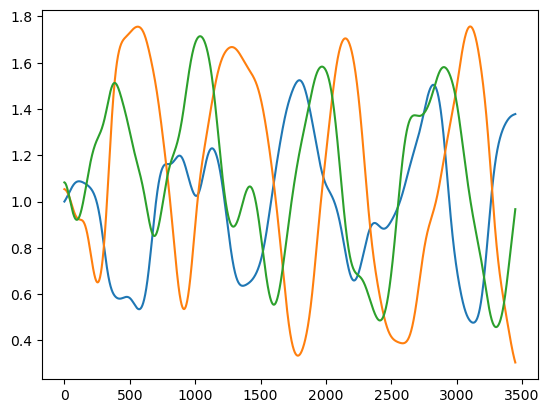

In [34]:
plt.plot(Rates[:,1])
plt.plot(Rates[:,0])
plt.plot(Rates[:,3])
# plt.plot(Rates[:,2])
# plt.plot(Rates[:,7])

Covariance off-diagonal RMS: 7.456045210710905e-05
Per-channel std (should be 1): [1. 1. 1. 1. 1.]


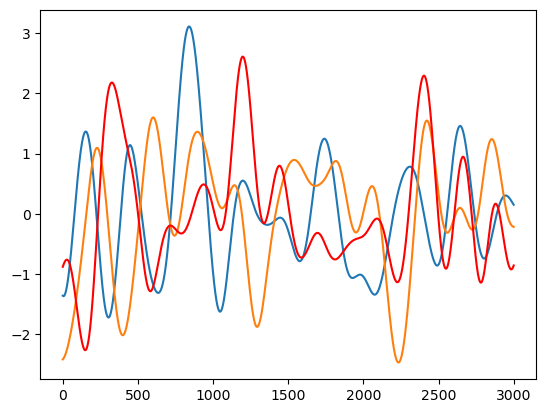

In [6]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.linalg import qr

X = Rates

# X: (T, N) original RNN rates matrix (or any data)
T, N = X.shape
k = 20   # desired number of channels

# 1) compute first k PCs (scores)
pca = PCA(n_components=k)
S = pca.fit_transform(X)   # S.shape == (T, k); columns are PC scores (zero-mean)

# 2) normalize each PC to unit std
S_norm = S / (S.std(axis=0, keepdims=True) + 1e-12)

# 3) make a random orthonormal matrix Q (k x k) and rotate
rng = np.random.default_rng(10)
A = rng.normal(size=(k, k))
Q, _ = qr(A)   # Q is orthonormal
Y = S_norm.dot(Q)   # Y.shape == (T, k) -> your new high-dim signals

# Diagnostics: covariance should be approx identity
cov = np.cov(Y, rowvar=False)
print("Covariance off-diagonal RMS:", np.sqrt(np.mean((cov - np.eye(k))**2)))
print("Per-channel std (should be 1):", Y.std(axis=0)[:5])


plt.plot(Y[:,0])
plt.plot(Y[:,1])
plt.plot(Y[:,18],"r")

In [592]:
cov

array([[ 1.00033344e+00,  5.20385483e-14, -2.64348433e-13,
        -1.99196000e-13,  3.34883838e-14,  1.24784478e-13,
        -5.47774193e-15,  1.78595236e-13, -1.89237977e-13,
        -4.38674253e-13, -3.61455151e-14, -2.98987096e-13,
        -1.33080609e-13,  1.98108507e-13,  2.26824006e-13,
        -3.72495928e-13, -2.72408675e-13, -1.73160141e-13,
         1.20766203e-13, -1.88512982e-13],
       [ 5.20385483e-14,  1.00033344e+00, -2.09357780e-13,
         5.81133452e-14,  1.28256044e-13,  3.67064387e-13,
         2.03349323e-13, -8.16976067e-14, -6.85665448e-14,
        -1.26035450e-13,  1.68511642e-13, -2.48517001e-13,
        -3.29351603e-14, -1.11033260e-13,  1.74908659e-13,
        -1.45340225e-13, -2.83951737e-13,  4.56296851e-14,
        -8.55044241e-14,  1.08408114e-13],
       [-2.64348433e-13, -2.09357780e-13,  1.00033344e+00,
        -2.13707752e-13, -1.54720740e-13, -1.44457674e-13,
        -3.30195061e-13, -5.90184046e-14, -1.20494922e-13,
        -4.81216786e-13,  1.4

In [573]:
Q

array([[-2.16867790e-01, -2.12920816e-01,  2.53629035e-01,
         1.16095280e-01,  4.82103332e-02,  6.75804199e-02,
        -3.71996485e-01, -9.31699791e-02,  1.14482145e-01,
        -2.36276013e-01,  7.79510955e-02,  3.29501421e-01,
         7.93825054e-02, -1.11110854e-01, -1.03989204e-01,
         2.56828083e-01, -3.98436639e-02, -4.08365760e-01,
         1.80796548e-01,  4.42532151e-01],
       [-1.93677554e-01, -3.00663664e-01,  2.41880992e-01,
         2.09818630e-02,  8.67908857e-02, -3.54308440e-01,
        -2.57209440e-02, -3.89541378e-02,  2.38411559e-01,
         1.09931570e-01, -1.87969329e-02,  2.88548560e-03,
         3.75891585e-01, -2.21940273e-01,  2.70622437e-01,
        -2.61627414e-01,  2.75766818e-01,  2.89452306e-01,
         3.20545936e-01, -1.17447322e-01],
       [-1.30583222e-01, -1.99626621e-01, -2.15957135e-01,
        -6.85557403e-02,  2.07662268e-02,  2.63827442e-01,
        -1.37661500e-01,  2.82520370e-01,  2.72403007e-01,
        -1.02913478e-01, -4.3

(20, 20)

In [572]:
cov_matrix = np.cov((Y).T)

# Compute eigenvalues of covariance matrix
eigenvalues = np.linalg.eigvalsh(cov_matrix)
(eigenvalues.sum())**2/(eigenvalues**2).sum()

19.999999999999996

In [514]:
cov_matrix

array([[ 0.45472748, -0.03376115,  0.09319385, ..., -0.0176896 ,
         0.31858312,  0.11537035],
       [-0.03376115,  0.50637778,  0.18438975, ...,  0.25181798,
         0.02452655, -0.23403808],
       [ 0.09319385,  0.18438975,  0.57068596, ...,  0.03366729,
         0.22063553, -0.18004732],
       ...,
       [-0.0176896 ,  0.25181798,  0.03366729, ...,  0.32886368,
        -0.02971084, -0.1226015 ],
       [ 0.31858312,  0.02452655,  0.22063553, ..., -0.02971084,
         0.51440779,  0.05834742],
       [ 0.11537035, -0.23403808, -0.18004732, ..., -0.1226015 ,
         0.05834742,  0.34695081]])

In [266]:
cov_matrix = np.cov((Rates-Rates.mean(axis=0)).T)

# Compute eigenvalues of covariance matrix
eigenvalues = np.linalg.eigvalsh(cov_matrix)
(eigenvalues.sum())**2/(eigenvalues**2).sum()

3.650754406933897

In [288]:
get_dimensionality(rates[5000::10])

9

In [331]:
get_dimensionality(Rates[:,:])

28

In [285]:
cov_matrix = np.cov((rates[:,[0,1,3]]).T)

# Compute eigenvalues of covariance matrix
eigenvalues = np.linalg.eigvalsh(cov_matrix)
eigenvalues

array([0.07829856, 0.36113029, 0.80027054])

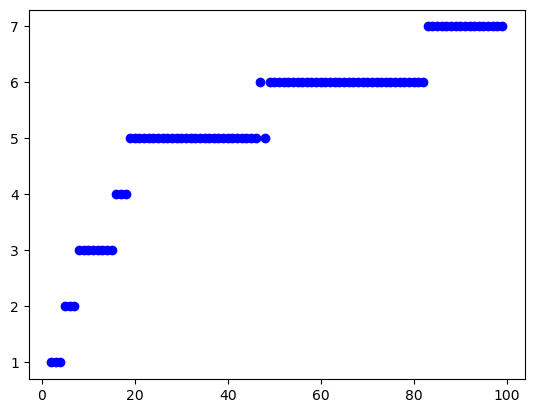

In [249]:
for i in range(2,100):
    dm = get_dimensionality(Rates[:,:i])
    plt.plot(i,dm,"bo")

In [236]:
cov_matrix = np.zeros((5,5))
for i in range(5):
    cov_matrix[i,i] = 4

eigenvalues = np.linalg.eigvalsh(cov_matrix)
(eigenvalues.sum())**2/(eigenvalues**2).sum()

5.0

In [237]:
eigenvalues

array([4., 4., 4., 4., 4.])

In [238]:
cov_matrix = np.zeros((6,6))
for i in range(5):
    cov_matrix[i,i] = 4
cov_matrix[5,5] = 4
cov_matrix[1,5] = 4
cov_matrix[5,1] = 4
eigenvalues = np.linalg.eigvalsh(cov_matrix)
(eigenvalues.sum())**2/(eigenvalues**2).sum()

4.5

In [239]:
eigenvalues

array([0., 4., 4., 4., 4., 8.])

In [240]:
import numpy as np
from scipy.linalg import eigvals

def get_dimensionality(neural_activity, n_iterations=100, percentile=95):
    """
    Get neural activity dimensionality using parallel analysis with permutation
    
    Parameters:
    -----------
    neural_activity : numpy.ndarray
        Neural activity matrix (timepoints × neurons)
    n_iterations : int, default=100
        Number of permutation iterations
    percentile : float, default=95
        Percentile threshold
        
    Returns:
    --------
    int : Number of significant dimensions
    """
    
    def _compute_eigenvalues(data):
        """Compute eigenvalues of covariance matrix"""
        # Standardize data
        data_std = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
        data_std = np.nan_to_num(data_std)
        
        # Covariance matrix eigenvalues
        cov_matrix = np.cov(data_std.T)
        eigenvals = eigvals(cov_matrix)
        return np.sort(np.real(eigenvals))[::-1]
    
    def _permute_data(data):
        """Permute each neuron's activity independently"""
        permuted = np.zeros_like(data)
        for i in range(data.shape[1]):
            permuted[:, i] = np.random.permutation(data[:, i])
        return permuted
    
    # Original eigenvalues
    original_eigs = _compute_eigenvalues(neural_activity)
    
    # Permuted eigenvalues (single CPU loop)
    random_eigs = []
    for _ in range(n_iterations):
        permuted_data = _permute_data(neural_activity)
        random_eigs.append(_compute_eigenvalues(permuted_data))
    
    random_eigs = np.array(random_eigs)
    
    # Thresholds and significant dimensions
    thresholds = np.percentile(random_eigs, percentile, axis=0)
    
    return np.sum(original_eigs > thresholds)

In [334]:
import numpy as np
from scipy.linalg import eigvals, eigh

def get_dimensionality_and_pcs(neural_activity, n_iterations=100, percentile=95):
    """
    Get neural activity dimensionality and principal components using parallel analysis
    
    Parameters:
    -----------
    neural_activity : numpy.ndarray
        Neural activity matrix (timepoints × neurons)
    n_iterations : int, default=100
        Number of permutation iterations
    percentile : float, default=95
        Percentile threshold
        
    Returns:
    --------
    dict : {'dimensionality': int, 'pca_components': ndarray, 'mean': ndarray}
           - dimensionality: number of significant dimensions
           - pca_components: PC axes (neurons × components), sorted by eigenvalue
           - mean: mean of each neuron for centering data
    """
    
    def _compute_eigenvalues(data):
        """Compute eigenvalues of covariance matrix"""
        # Standardize data
        data_std = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
        data_std = np.nan_to_num(data_std)
        
        # Covariance matrix eigenvalues
        cov_matrix = np.cov(data_std.T)
        eigenvals = eigvals(cov_matrix)
        return np.sort(np.real(eigenvals))[::-1]
    
    def _permute_data(data):
        """Permute each neuron's activity independently"""
        permuted = np.zeros_like(data)
        for i in range(data.shape[1]):
            permuted[:, i] = np.random.permutation(data[:, i])
        return permuted
    
    # Standardize original data
    data_mean = np.mean(neural_activity, axis=0)
    data_std = np.std(neural_activity, axis=0)
    neural_activity_std = (neural_activity - data_mean) / data_std
    neural_activity_std = np.nan_to_num(neural_activity_std)
    
    # Compute PCA on standardized data
    cov_matrix = np.cov(neural_activity_std.T)
    eigenvals_orig, eigenvects = eigh(cov_matrix)
    
    # Sort by eigenvalue (descending)
    sort_idx = np.argsort(eigenvals_orig)[::-1]
    eigenvals_orig = eigenvals_orig[sort_idx]
    pca_components = eigenvects[:, sort_idx]  # neurons × components
    
    # Permuted eigenvalues (single CPU loop)
    random_eigs = []
    for _ in range(n_iterations):
        permuted_data = _permute_data(neural_activity)
        random_eigs.append(_compute_eigenvalues(permuted_data))
    
    random_eigs = np.array(random_eigs)
    
    # Thresholds and significant dimensions
    thresholds = np.percentile(random_eigs, percentile, axis=0)
    dimensionality = np.sum(eigenvals_orig > thresholds)
    
    return {
        'dimensionality': dimensionality,
        'pca_components': pca_components,
        'mean': data_mean,
        'std': data_std
    }

def get_dimensionality(neural_activity, n_iterations=100, percentile=95):
    """
    Get just the dimensionality (for backward compatibility)
    """
    result = get_dimensionality_and_pcs(neural_activity, n_iterations, percentile)
    return result['dimensionality']

def project_to_pcs(neural_activity, pca_result, n_components):
    """
    Project neural activity onto specified number of principal components
    
    Parameters:
    -----------
    neural_activity : numpy.ndarray
        Neural activity matrix (timepoints × neurons)
    pca_result : dict
        Result from get_dimensionality_and_pcs()
    n_components : int
        Number of PC components to project onto
        
    Returns:
    --------
    numpy.ndarray : Projected activity (timepoints × n_components)
    """
    
    # Standardize data using original mean and std
    neural_activity_std = ((neural_activity - pca_result['mean']) / 
                          pca_result['std'])
    neural_activity_std = np.nan_to_num(neural_activity_std)
    
    # Project onto first n_components
    pc_axes = pca_result['pca_components'][:, :n_components]  # neurons × n_components
    projected_activity = neural_activity_std @ pc_axes  # timepoints × n_components
    
    return projected_activity

In [525]:
result = get_dimensionality_and_pcs(Rates,n_iterations=1)
dimensionality = result['dimensionality']
pc_components = result['pca_components']  # neurons × components (sorted by importance)


In [526]:

# 2. Project activity onto first 4 PCs
projected_activity = project_to_pcs(Rates, result, n_components=20)

In [527]:
dimensionality

9

In [528]:
projected_activity.shape

(3000, 20)

In [529]:
projected_activity = projected_activity/projected_activity.std(axis=0)

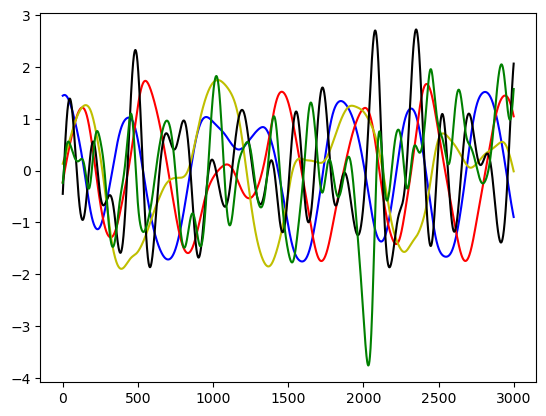

In [530]:
plt.plot(projected_activity[:,0],"b")
plt.plot(projected_activity[:,1],"r")
plt.plot(projected_activity[:,2],"y")
plt.plot(projected_activity[:,5],"k")
plt.plot(projected_activity[:,19],"g")

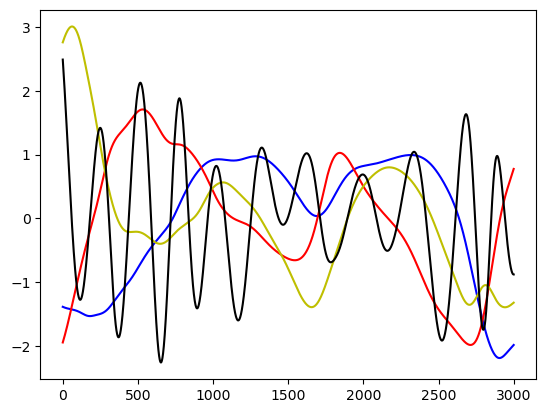

In [487]:
plt.plot(projected_activity[:,0],"b")
plt.plot(projected_activity[:,1],"r")
plt.plot(projected_activity[:,2],"y")
plt.plot(projected_activity[:,-2],"k")

In [438]:
projected_activity.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [441]:
cov_matrix = np.cov((projected_activity+4).T)

# Compute eigenvalues of covariance matrix
eigenvalues = np.linalg.eigvalsh(cov_matrix)
(eigenvalues.sum())**2/(eigenvalues**2).sum()

17.999999999999993

In [447]:
cov_matrix[0,-2]

-1.1372474597027277e-16

In [442]:
for i in range(18):
    print(cov_matrix[i,i])

1.0003334444814929
1.0003334444814949
1.0003334444814935
1.000333444481493
1.0003334444814926
1.0003334444814953
1.000333444481491
1.0003334444814924
1.0003334444814942
1.000333444481493
1.000333444481494
1.000333444481497
1.0003334444814918
1.000333444481497
1.0003334444814922
1.0003334444814969
1.0003334444814929
1.0003334444814962


In [448]:
for i in range(18):
    for j in range(18):
        if np.abs(cov_matrix[i,j]) > 1e-3:
            print(i,j)

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17


In [443]:
result = get_dimensionality_and_pcs(projected_activity)
dimensionality = result['dimensionality']
pc_components = result['pca_components'] 

In [445]:
eigenvalues

array([1.00033344, 1.00033344, 1.00033344, 1.00033344, 1.00033344,
       1.00033344, 1.00033344, 1.00033344, 1.00033344, 1.00033344,
       1.00033344, 1.00033344, 1.00033344, 1.00033344, 1.00033344,
       1.00033344, 1.00033344, 1.00033344])

In [389]:
import numpy as np

def random_assign_signals(signals, n_channels, seed=None):
    """
    Randomly assign columns from a signals matrix (shape: timepoints x n_signal_columns)
    to a new matrix with n_channels columns (with replacement).
    
    Args:
        signals (np.ndarray): shape (n_timepoints, n_signal_columns)
        n_channels (int): desired number of output columns
        seed (int or None): random seed
    
    Returns:
        np.ndarray: shape (n_timepoints, n_channels)
    """
    rng = np.random.default_rng(seed)
    n_timepoints, n_signal_columns = signals.shape
    assign_idx = rng.choice(n_signal_columns, size=n_channels, replace=True)
    new_matrix = signals[:, assign_idx]
    return new_matrix


out_matrix = random_assign_signals(projected_activity, n_channels=20, seed=42)
print(f"Output shape: {out_matrix.shape}")  # should be (n_timepoints, 20)


Output shape: (3000, 20)


In [390]:
get_dimensionality_and_pcs(out_matrix)

{'dimensionality': 7,
 'pca_components': array([[ 5.74351401e-01,  5.87690500e-02,  5.95523271e-16,
          1.33749052e-15, -3.31159490e-16, -2.49439848e-17,
          1.83925099e-16, -2.42348355e-17, -3.76530595e-16,
         -2.42422964e-16,  2.99227814e-17, -3.70609430e-18,
          2.38450904e-01,  0.00000000e+00,  1.00972114e-01,
          2.48888249e-02, -2.13846696e-01,  1.79127509e-01,
          7.21924638e-01, -8.68209807e-04],
        [ 5.87690500e-02, -5.74351401e-01,  1.01566534e-15,
         -1.15654816e-15, -2.17478764e-15, -3.31238616e-15,
          2.61507940e-16,  2.51413126e-16, -4.21202722e-16,
         -5.04217577e-16,  1.79472733e-16,  1.67300413e-17,
         -7.10574601e-01,  4.18299655e-32, -2.26346319e-01,
         -3.78718554e-02,  1.36833019e-01,  4.32092257e-02,
          2.97475088e-01, -1.31498128e-03],
        [ 1.77412300e-15,  6.01010406e-16, -2.09874910e-01,
         -6.63602385e-01,  1.24004830e-01,  1.43944166e-02,
         -1.01307851e-15, -1.405

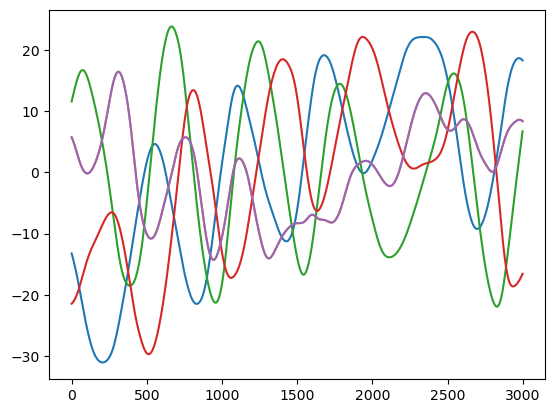

In [361]:
plt.plot(out_matrix[:,0])
plt.plot(out_matrix[:,1])
plt.plot(out_matrix[:,2])
plt.plot(out_matrix[:,4])
plt.plot(out_matrix[:,5])

In [534]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.linalg import qr

X = Rates

# X: (T, N) original RNN rates matrix (or any data)
T, N = X.shape
k = 20   # desired number of channels

# 1) compute first k PCs (scores)
pca = PCA(n_components=k)
S = pca.fit_transform(X)   # S.shape == (T, k); columns are PC scores (zero-mean)

# 2) normalize each PC to unit std
S_norm = S / (S.std(axis=0, keepdims=True) + 1e-12)

# 3) make a random orthonormal matrix Q (k x k) and rotate
rng = np.random.default_rng(0)
A = rng.normal(size=(k, k))
Q, _ = qr(A)   # Q is orthonormal
Y = S_norm.dot(Q)   # Y.shape == (T, k) -> your new high-dim signals

# Diagnostics: covariance should be approx identity
cov = np.cov(Y, rowvar=False)
print("Covariance off-diagonal RMS:", np.sqrt(np.mean((cov - np.eye(k))**2)))
print("Per-channel std (should be 1):", Y.std(axis=0)[:5])


plt.plot(Y[:,0])
plt.plot(Y[:,1])

Covariance off-diagonal RMS: 7.456045180855206e-05
Per-channel std (should be 1): [1. 1. 1. 1. 1.]


In [535]:
Y.shape

(3000, 20)

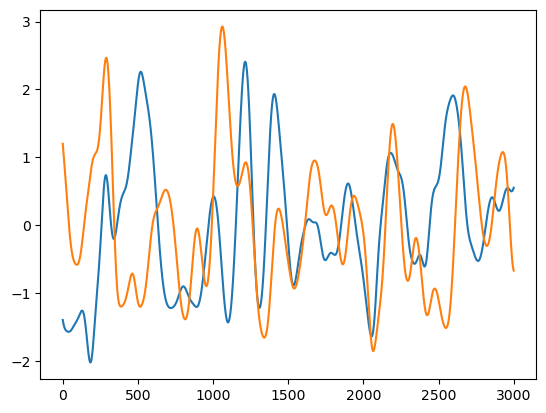

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.linalg import qr
from scipy.signal import welch

# Rate RNN simulation (cleaned and documented)
def run_rate_rnn(n_neurons, T, dt, g=4.5, seed=None):
    np.random.seed(seed)
    n_steps = int(T // dt)
    time = np.arange(0, T, dt)
    W = np.random.normal(0, 1/np.sqrt(n_neurons), (n_neurons, n_neurons))
    np.fill_diagonal(W, 0)
    x = np.random.randn(n_neurons) * 0.1
    rates = np.zeros((n_steps, n_neurons))
    for t_idx in range(n_steps):
        phi_x = np.tanh(x)
        dx = -x + g * W @ phi_x
        x += dx * dt / 2
        rates[t_idx] = phi_x
    return rates, time

# Simulation parameters
n_neurons = 1000
T = 350
dt = 1
rates, time = run_rate_rnn(n_neurons, T, dt, g=1.2, seed=400)
Rates = rates[50:]

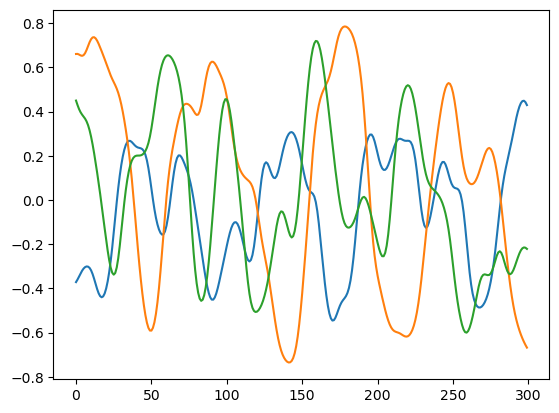

In [39]:
plt.plot(Rates[:,1])
plt.plot(Rates[:,0])
plt.plot(Rates[:,3])

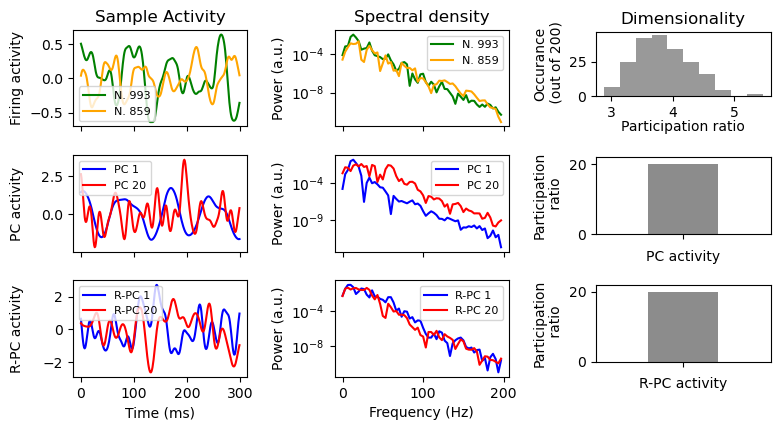

In [126]:
freq_max = 200  # max frequency to show (Hz)

colors = ["g","orange"]

fig, axs = plt.subplots(3, 3, figsize=(9, 4.5))

# 1. Raw activity for 3 random neurons
np.random.seed(0)
neuron_indices = np.random.choice(Rates.shape[1], 2, replace=False)
for i, idx in enumerate(neuron_indices):
    axs[0, 0].plot(Rates[:, idx], label=f'N. {idx}',c=colors[i])
axs[0, 0].set_title('Sample Activity')
axs[0, 0].legend(fontsize=8)

# 2. Spectral power for same 3
fs = 1000 / dt
for i, idx in enumerate(neuron_indices):
    f, Pxx = welch(Rates[:, idx], fs=fs, nperseg=min(512, len(Rates)))
    freq_lim = np.searchsorted(f, freq_max)  # index cutoff
    axs[0, 1].semilogy(f[:freq_lim], Pxx[:freq_lim], label=f'N. {idx}',c=colors[i])
axs[0, 1].set_title('Spectral density')
axs[0, 1].legend(fontsize=8)

# 3. Participation ratio for 100 random selections of 20 neurons
part_ratios = []
for _ in range(200):
    idx = np.random.choice(Rates.shape[1], 20, replace=False)
    X = Rates[:, idx]
    eig = np.linalg.eigvalsh(np.cov(X, rowvar=False))
    part_ratio = (np.sum(eig) ** 2) / np.sum(eig ** 2)
    part_ratios.append(part_ratio)
axs[0, 2].hist(part_ratios, bins=10, color='grey', alpha=0.8)
axs[0, 2].set_title('Dimensionality')
axs[0, 2].set_ylabel('Occurance\n (out of 200)')




colors = ["b","r"]
# 4. PCA analysis: activity for PCs 1, 10, 20
k = 20
pca = PCA(n_components=k)
S = pca.fit_transform(Rates)
S_norm = S / (S.std(axis=0, keepdims=True) + 1e-12)
for pc_idx, pc in enumerate([0, 19]):
    axs[1, 0].plot(S_norm[:, pc], label=f'PC {pc+1}',c=colors[pc_idx])

axs[1, 0].legend(fontsize=8)

# 5. Spectra for PC 1, 10, 20
for pc_idx, pc in enumerate([0, 19]):
    f, Pxx = welch(S_norm[:, pc], fs=fs, nperseg=min(512, len(Rates)))
    freq_lim = np.searchsorted(f, freq_max)
    axs[1, 1].semilogy(f[:freq_lim], Pxx[:freq_lim], label=f'PC {pc+1}',c=colors[pc_idx])

axs[1, 1].legend(fontsize=8)

# 6. Participation ratio for 20 PCA activity channels
eig_pca = np.linalg.eigvalsh(np.cov(S_norm, rowvar=False))
part_ratio_pca = (np.sum(eig_pca) ** 2) / np.sum(eig_pca ** 2)
axs[1, 2].bar([0], [part_ratio_pca], color='grey', alpha=0.9)

axs[1, 2].set_xticks([0])
axs[1, 2].set_xticklabels([])
axs[1,2].set_xlabel("PC activity")
axs[1, 2].set_xlim((-1,1))
axs[1, 2].set_ylim(0, k+2)

# 7. Random orthonormal rotation
rng = np.random.default_rng(10)
A = rng.normal(size=(k, k))
Q, _ = qr(A)
Y = S_norm @ Q
for i, ch in enumerate([0, 19]):
    axs[2, 0].plot(Y[:, ch], label=f'R-PC {ch+1}',c=colors[i])

axs[2, 0].legend(fontsize=8)

# 8. Spectra for random-rotated: channels 1, 10, 20
for i, ch in enumerate([0, 19]):
    f, Pxx = welch(Y[:, ch], fs=fs, nperseg=min(512, len(Rates)))
    freq_lim = np.searchsorted(f, freq_max)
    axs[2, 1].semilogy(f[:freq_lim], Pxx[:freq_lim], label=f'R-PC {ch+1}',c=colors[i])

axs[2, 1].set_xlabel('Frequency (Hz)')
axs[2, 1].legend(fontsize=8)

cov = np.cov(Y, rowvar=False)
eig_rot = np.linalg.eigvalsh(cov)
part_ratio_rot = (np.sum(eig_rot) ** 2) / np.sum(eig_rot ** 2)
axs[2, 2].bar([0], [part_ratio_rot], color='grey', alpha=0.9)

axs[2, 2].set_xticks([0])
axs[2, 2].set_xticklabels([])
axs[2,2].set_xlabel("R-PC activity")
axs[2, 2].set_xlim((-1,1))
axs[2, 2].set_ylim(0, k+2)

axs[0,0].set_ylabel("Firing activity")
axs[1,0].set_ylabel("PC activity")
axs[2,0].set_ylabel("R-PC activity")
axs[2,0].set_xlabel("Time (ms)")
for i in range(2):
    axs[i,0].set_xticks([0,100,200,300])
    axs[i,0].set_xticklabels([])

    axs[i,1].set_xticks([0,100,200])
    axs[i,1].set_xticklabels([])

for i in range(3):
    axs[i,1].set_ylabel("Power (a.u.)")

for i in range(1,3):
    axs[i,2].set_ylabel("Participation\n ratio")
# plt.tight_layout()

axs[0, 2].set_xlabel('Participation ratio', labelpad=0)
fig.align_ylabels(axs[:, 0])

fig.subplots_adjust(hspace=0.3, wspace=0.5)

pos_01 = axs[0,1].get_position()  # bbox of axs[0,1]
pos_02 = axs[0,2].get_position()  # current bbox of axs[0,2]
# Create a new bbox with the same bottom as axs[0,1], but keep width and left as is
new_pos_02 = [pos_02.x0, 1.1*pos_02.y0, pos_02.width, 0.67*pos_02.height]
# Set the new position of axs[0,2]
axs[0,2].set_position(new_pos_02)

pos_01 = axs[1,1].get_position()  # bbox of axs[0,1]
pos_02 = axs[1,2].get_position()  # current bbox of axs[0,2]
# Create a new bbox with the same bottom as axs[0,1], but keep width and left as is
new_pos_02 = [pos_02.x0, 1.1*pos_02.y0, pos_02.width, 0.8*pos_02.height]
# Set the new position of axs[0,2]
axs[1,2].set_position(new_pos_02)

pos_01 = axs[2,1].get_position()  # bbox of axs[0,1]
pos_02 = axs[2,2].get_position()  # current bbox of axs[0,2]
# Create a new bbox with the same bottom as axs[0,1], but keep width and left as is
new_pos_02 = [pos_02.x0, 1.3*pos_02.y0, pos_02.width, 0.8*pos_02.height]
# Set the new position of axs[0,2]
axs[2,2].set_position(new_pos_02)

plt.show()


In [129]:
rng = np.random.default_rng(1)
rng.normal(0,1,10)

array([ 0.34558419,  0.82161814,  0.33043708, -1.30315723,  0.90535587,
        0.44637457, -0.53695324,  0.5811181 ,  0.3645724 ,  0.2941325 ])

In [130]:
rng = np.random.default_rng(1)
rng.normal(0,10,10)

array([  3.45584192,   8.21618144,   3.30437076, -13.03157232,
         9.05355867,   4.46374572,  -5.36953235,   5.81118104,
         3.64572396,   2.94132497])